In [25]:
import os
import time

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec

%matplotlib inline

print("Package is ready.")

Package is ready.


In [37]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 18})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

In [3]:
N_FOLD = 5
N_TASKS = 6
TIME_STEP = 144
OUTPUT_SIZE = 12
INTERVAL = pd.Timedelta("10 min")
pred_results = []
#PRED_COL = ['temp', 'rh', 'ec', 'co2', 'atm', 'uv', 'rad', 's_temp', 's_rh']
PRED_COL = ['temp', 'rh', 'co2', 'rad', 's_temp', 's_rh']

# Prediction Results

In [4]:
pred_dfs = []
pred_labels = []
for i in range(5):
    pred_df = pd.read_csv("./results/output_Allenv_altMT-LN-LSTM_T144_I10 min_F"+str(i+1)+".CSV", index_col="Unnamed: 0")
    pred_label = pd.read_csv("./results/labels_Allenv_altMT-LN-LSTM_T144_I10 min_F"+str(i+1)+".CSV", index_col=["Unnamed: 0"])
    pred_df.index = pd.DatetimeIndex(pred_df.index)
    pred_label.index = pd.DatetimeIndex(pred_label.index)
    pred_dfs.append(pred_df)
    pred_labels.append(pred_label)
pred_df = pd.concat(pred_dfs)
pred_label = pd.concat(pred_labels)
pred_df = pred_df[~pred_df.index.duplicated()]
pred_label = pred_label[~pred_label.index.duplicated()]

In [5]:
pred_df_set = []
pred_lb_set = []
for i in range(N_TASKS):
    pred_df_set.append(pred_df.iloc[:, i*OUTPUT_SIZE:(i+1)*OUTPUT_SIZE])
    pred_lb_set.append(pred_label.iloc[:, i*OUTPUT_SIZE:(i+1)*OUTPUT_SIZE])

In [6]:
for i in range(len(pred_df_set)):
    COLUMNS = []
    for j in range(pred_df_set[i].shape[1]):
        COLUMNS.append(INTERVAL*j)
    pred_df_set[i].columns = COLUMNS
    pred_lb_set[i].columns = COLUMNS

In [7]:
pred_df_set[0]

,0 days 00:00:00,0 days 00:10:00,0 days 00:20:00,0 days 00:30:00,0 days 00:40:00,0 days 00:50:00,0 days 01:00:00,0 days 01:10:00,0 days 01:20:00,0 days 01:30:00,0 days 01:40:00,0 days 01:50:00
2016-10-03 00:00:00,25.999527,25.502613,25.595121,25.134586,25.859203,25.542158,25.705800,25.832660,25.303001,25.969248,25.786303,25.709780
2016-10-03 00:10:00,25.885324,25.391365,25.466042,25.016064,25.702510,25.379570,25.529879,25.646086,25.115942,25.758863,25.570225,25.500677
2016-10-03 00:20:00,25.859697,25.369720,25.440117,25.003939,25.679314,25.346956,25.496838,25.610073,25.081995,25.717474,25.530525,25.459711
2016-10-03 00:30:00,25.930407,25.449362,25.527224,25.114355,25.798723,25.452055,25.615572,25.731250,25.206131,25.847504,25.664389,25.594534
2016-10-03 00:40:00,26.070137,25.560670,25.615433,25.122427,25.782158,25.483904,25.608501,25.715958,25.161146,25.795675,25.576881,25.538916
2016-10-03 00:50:00,26.033333,25.512820,25.583076,25.103748,25.804003,25.473621,25.614944,25.731700,25.189201,25.839825,25.651117,25.559942
2016-10-03 01:00:00,26.029300,25.540169,25.624890,25.168648,25.871810,25.561361,25.719786,25.841433,25.306995,25.963947,25.768547,25.715523
2016-10-03 01:10:00,25.937744,25.451720,25.505198,25.046131,25.684523,25.383865,25.513374,25.617860,25.074636,25.695633,25.479643,25.454640
2016-10-03 01:20:00,26.032461,25.529507,25.604498,25.133291,25.828472,25.514814,25.661238,25.779230,25.239240,25.890213,25.693905,25.629648
2016-10-03 01:30:00,25.996553,25.481150,25.554052,25.099160,25.800905,25.450533,25.601133,25.717585,25.181130,25.830603,25.649998,25.549393


In [8]:
predictions = []
pred_labels = []
for _ in range(len(pred_df_set)):
    l1 = []
    l2 = []
    print(_+1)
    for i in range(0, pred_df_set[_].shape[1]):
        print(i+1, end=" ")
        temp = pred_df_set[_].iloc[:, i].copy()
        temp.index += INTERVAL*i
        temp = pd.DataFrame(temp)
        temp.columns = [_]
        l1.append(temp)

        temp = pred_lb_set[_].iloc[:, i].copy()
        temp.index += INTERVAL*i
        temp = pd.DataFrame(temp)
        temp.columns = [_]
        l2.append(temp)
    print("")
    predictions.append(pd.concat(l1, axis=1))
    pred_labels.append(pd.concat(l2, axis=1))
    

1
1 2 3 4 5 6 7 8 9 10 11 12 
2
1 2 3 4 5 6 7 8 9 10 11 12 
3
1 2 3 4 5 6 7 8 9 10 11 12 
4
1 2 3 4 5 6 7 8 9 10 11 12 
5
1 2 3 4 5 6 7 8 9 10 11 12 
6
1 2 3 4 5 6 7 8 9 10 11 12 


In [9]:
for i in range(N_TASKS):
    print(r2_score(pred_labels[i].dropna(), predictions[i].dropna()))

0.8716772920545416
0.8688008286407997
0.6941545851199985
0.8420388477412343
0.9776019249301254
0.9765276410811804


In [10]:
for i in range(N_TASKS):
    print(r2_score(pred_labels[i].dropna(), predictions[i].dropna()))

0.8716772920545416
0.8688008286407997
0.6941545851199985
0.8420388477412343
0.9776019249301254
0.9765276410811804


In [11]:
pred_means = []
pred_maxs = []
pred_mins = []

for i in range(len(predictions)):
    pred_means.append(predictions[i].mean(axis=1, skipna=True))
    pred_maxs.append(predictions[i].max(axis=1, skipna=True))
    pred_mins.append(predictions[i].min(axis=1, skipna=True))

In [12]:
label_means = []
for i in range(len(pred_labels)):
    label_means.append(pred_labels[i].mean(axis=1, skipna=True))

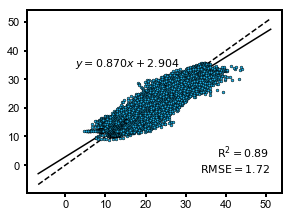

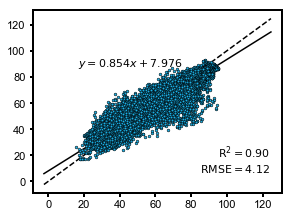

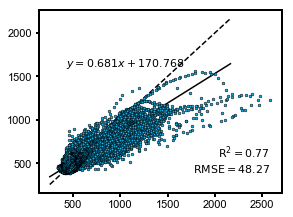

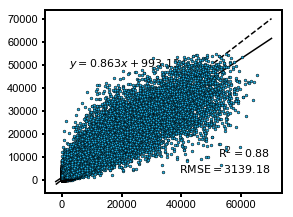

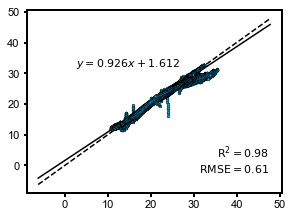

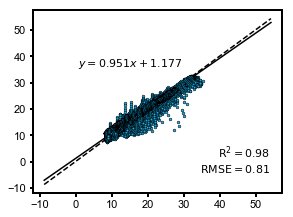

In [13]:
for i in range(len(predictions)):
    min_ = min(predictions[i].min())
    max_ = max(predictions[i].max())
    x_ = np.arange(min(predictions[i].min()) - 15, max(predictions[i].max()) + 15).reshape(-1,1)

    X, Y = pred_labels[i].mean(axis=1).values.reshape(-1, 1), predictions[i].mean(axis=1).values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    Yp = regr.predict(X)
    reg_x = x_
    reg_y = reg_x*regr.coef_ + regr.intercept_

    fig = plt.figure(figsize = ((8/2.54)*(8/6), (6/2.54)*(8/6)))
    ax = plt.subplot()
    x_linear = x_
    y_linear = x_linear

    reg_line = ax.plot(reg_x, reg_y, "k-", label = "regression line", zorder=7)
    linear = ax.plot(x_linear, y_linear, "k--", label = "1:1 line", zorder=5)
    scatter = ax.scatter(pred_labels[i].mean(axis=1), predictions[i].mean(axis=1), edgecolor='black', linewidth=0.5, 
                         s=MARKER_SIZE/2, c=cmap[4], label = "$CO_2$ concentration", zorder=10)
    if regr.intercept_ < 0:
        ax.text(0.6, 0.67, '$\it{y = %.3fx%.3f}$' % (regr.coef_, regr.intercept_),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    else:
        ax.text(0.6, 0.67, '$\it{y = %.3fx+%.3f}$' % (regr.coef_, regr.intercept_),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.95, 0.1, '$R^{2} = %.2f$\n$RMSE = %.2f$' % (r2_score(Y, Yp), np.sqrt(mean_squared_error(Y, Yp))),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    #ax.legend(handles = [scatter], frameon = False)
    # plt.xlabel("Measured $CO_2$ ($\mu mol \cdot mol^{-1}$)")
    # plt.ylabel("Estimated $CO_2$ ($\mu mol \cdot mol^{-1}$)")
    # plt.axis([200, 3000, 200, 3000])
    fig.tight_layout()
    # fig.savefig("./figures/Fig5.png", dpi=600, transparent=True, format="png")
    plt.show()

temp


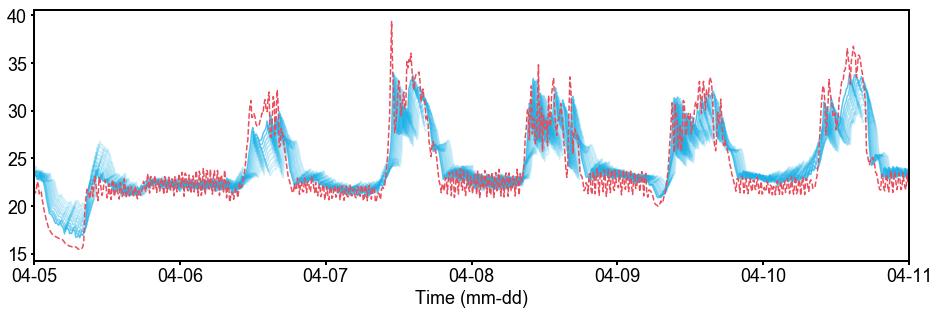

rh


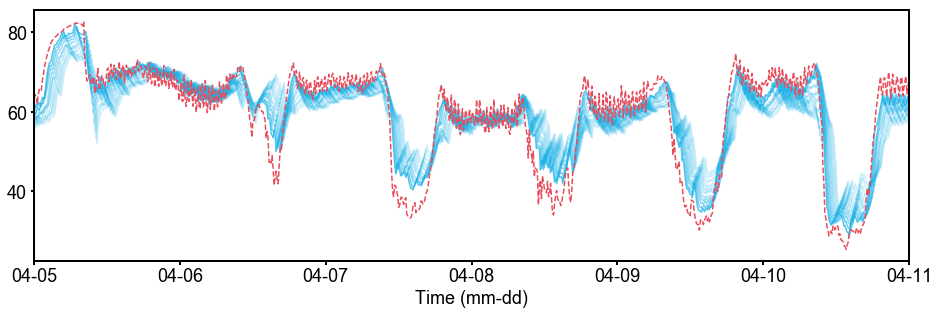

co2


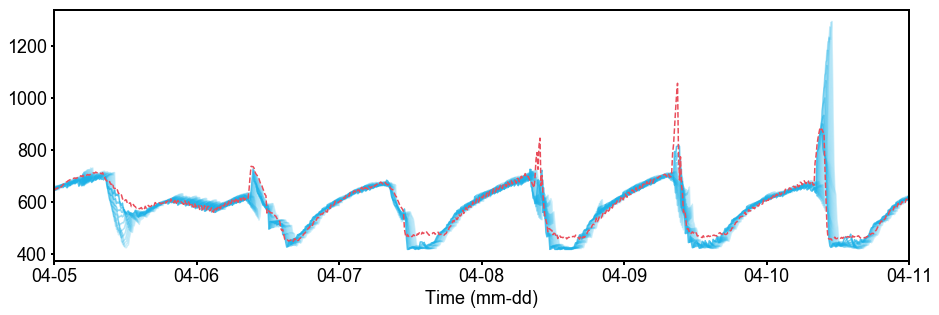

rad


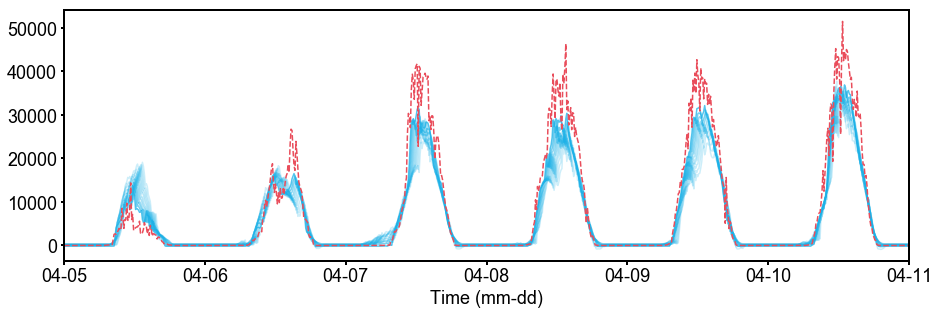

s_temp


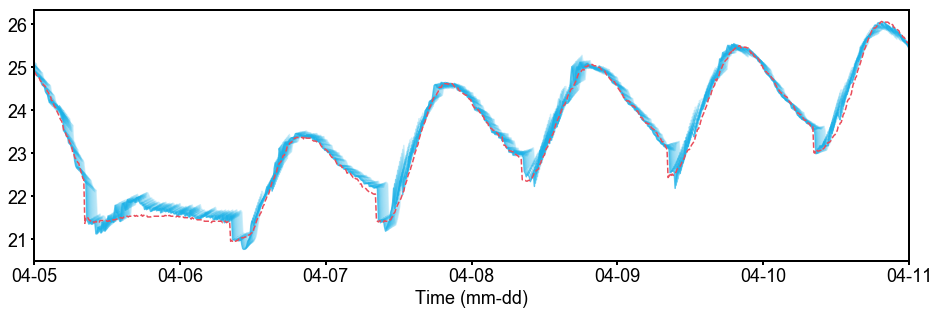

s_rh


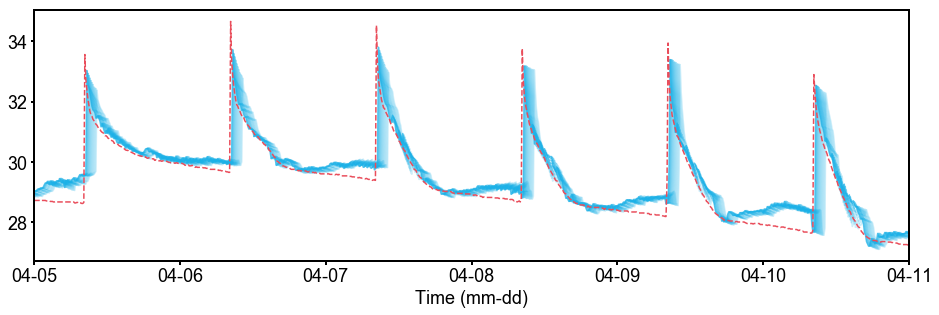

In [38]:
for i in range(len(predictions)):
    print(PRED_COL[i])
    x_date = predictions[i].loc[datetime.date(2017, 4, 5):datetime.date(2017, 4, 11)].index
    fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*2))
    ax = plt.subplot()

    #ax.fill_between(x_date, pred_mins[i], pred_maxs[i], facecolor=cmap[-2], alpha=0.5)

    
    for j in range(1, predictions[i].shape[1]):
        pred = predictions[i].loc[datetime.date(2017, 4, 5):datetime.date(2017, 4, 11)]
        lab = label_means[i].loc[datetime.date(2017, 4, 5):datetime.date(2017, 4, 11)]
        a, = ax.plot(x_date, pred.iloc[:,j], "-", markersize=MARKER_SIZE, c=cmap[4], alpha=1/(j/3+1))
    linear_label, = ax.plot(x_date, lab, "--", markersize=MARKER_SIZE, c=cmap[0])
#     ax.plot(x_date, predictions[i].iloc[:,0], "-", markersize=MARKER_SIZE, c=cmap[5])
#     ax.plot(x_date, predictions[i].iloc[:,11], "-", markersize=MARKER_SIZE, c=cmap[6])
#    linear_mean, = ax.plot(x_date, pred_means[i], "-", markersize=MARKER_SIZE, c=cmap[4])

    #plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

    #months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
    #ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    # mondays = WeekdayLocator(MONDAY)
    # ax.xaxis.set_minor_locator(mondays)


    plt.xlabel("Time (mm-dd)")
    #plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
    ax.set_xbound([datetime.date(2017, 4, 5), datetime.date(2017, 4, 11)])
    #ax.set_ybound([300, 1400])
    fig.tight_layout()
    fig.savefig("./figures/Fig6_" + str(i) + ".png", dpi=600, transparent=True, format="png")
    plt.show()

# Growth Environment

In [15]:
env_df = pd.read_csv("../../data/BR_env/forced_env.csv", index_col="Unnamed: 0")
env_df.index = pd.DatetimeIndex(env_df.index)

In [16]:
weather_env = env_df[[col for col in env_df.columns if '.w' in col]].copy()
soil_env = env_df[[col for col in env_df.columns if 's_' in col]].copy()
env_df.drop([col for col in env_df.columns if '.w' in col], axis=1, inplace=True)
env_df.drop([col for col in env_df.columns if 's_' in col], axis=1, inplace=True)

In [17]:
__ = []
_ = env_df[[col for col in env_df.columns if 'temp' in col]].mean(axis=1); _.name = "temp"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'rh' in col]].mean(axis=1); _.name = "rh"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'ec' in col]].mean(axis=1); _.name = "EC"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'co2' in col]].mean(axis=1); _.name = "CO2"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'atm' in col]].mean(axis=1); _.name = "atm"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'uv' in col]].mean(axis=1); _.name = "UV"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'rad' in col]].mean(axis=1); _.name = "rad"; __.append(pd.DataFrame(_))
env_mean = pd.concat(__, axis=1)

In [18]:
__ = []
_ = soil_env[[col for col in soil_env.columns if 'temp' in col]].mean(axis=1); _.name = "temp"; __.append(pd.DataFrame(_))
_ = soil_env[[col for col in soil_env.columns if 'rh' in col]].mean(axis=1); _.name = "rh"; __.append(pd.DataFrame(_))
soil_env_mean = pd.concat(__, axis=1)

In [19]:
env_date = pd.date_range(env_mean.index[0], env_df.index[-1], freq="10min")

In [20]:
#Dropping outlier
__ = env_mean[["rad"]].copy()
env_mean = env_mean[np.abs(env_mean-env_mean.mean())<=(3*env_mean.std())]
#env_df.loc["2018-01-21 11:50:00", "RootTemp(1)"] = pd.np.nan
env_df["rad"] = __

## Greenhouse

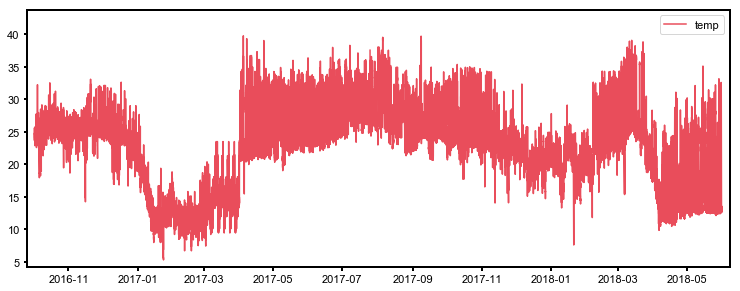

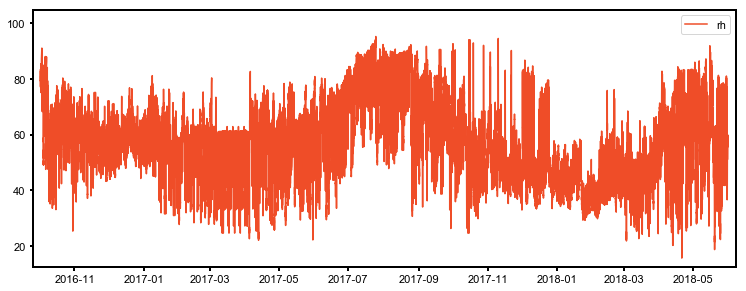

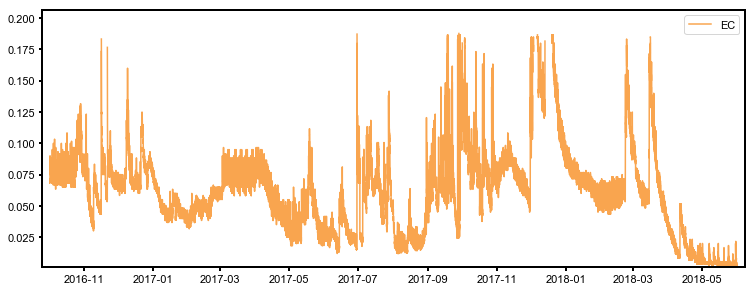

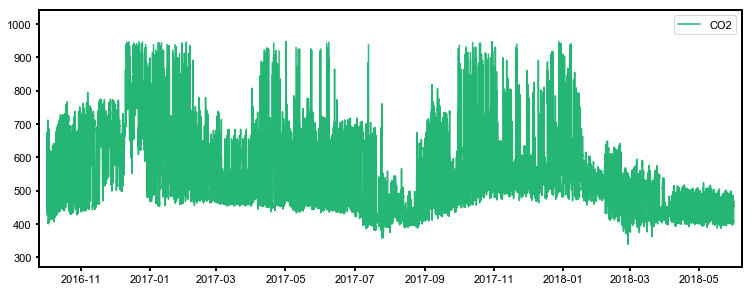

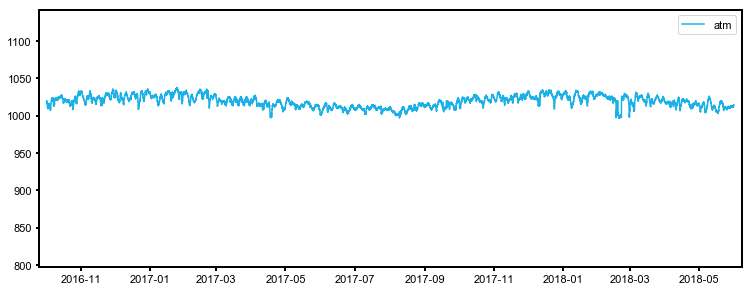

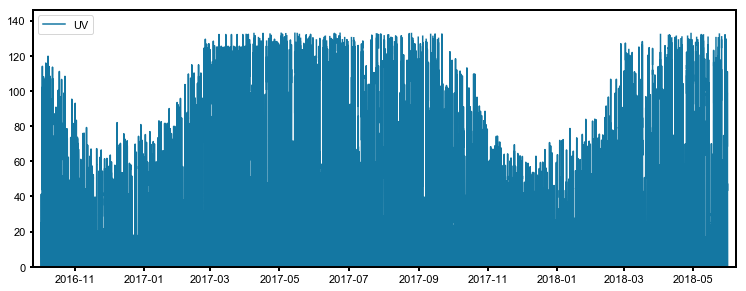

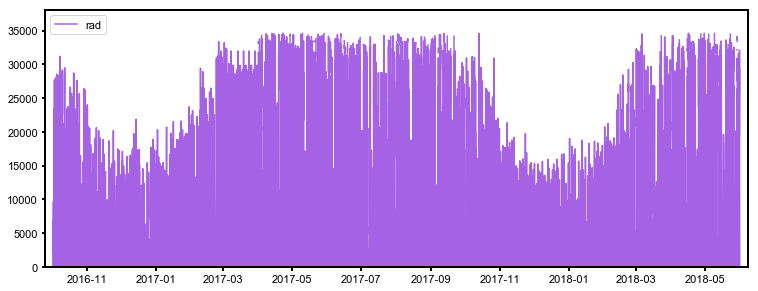

In [21]:
for _ in range(env_mean.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(env_mean.index, env_mean.iloc[:, _], c=cmap[_], label = env_mean.columns[_])
    plt.legend(handles=line)
    plt.axis([env_mean.index[0] - pd.Timedelta('7d'), env_mean.index[-1] + pd.Timedelta('7d'),
              env_mean.iloc[:, _].min() - abs(env_mean.iloc[:, _].min()*0.2), env_mean.iloc[:, _].max()*1.1])
    plt.show()

## Weather

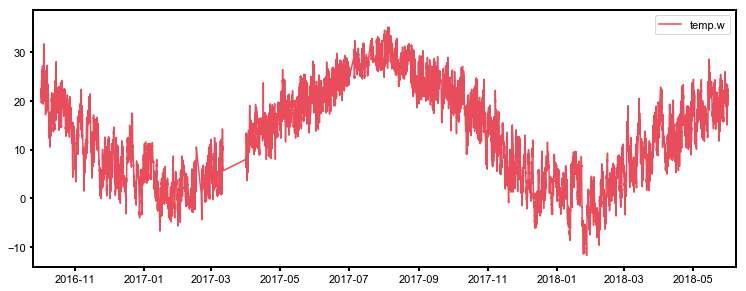

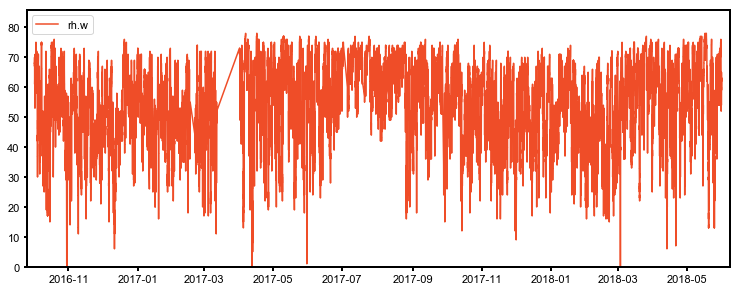

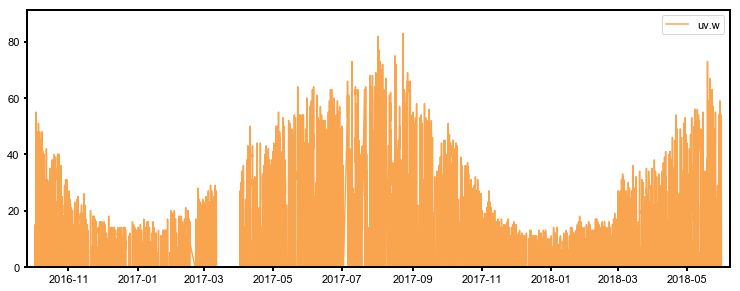

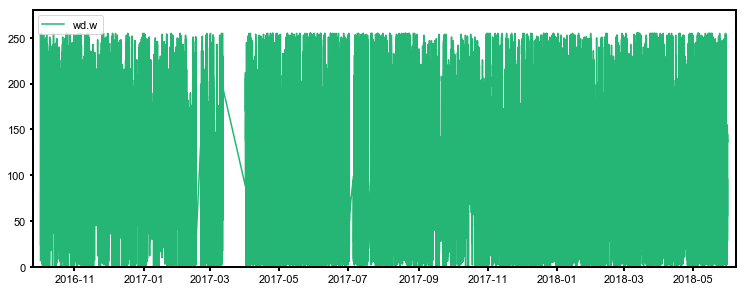

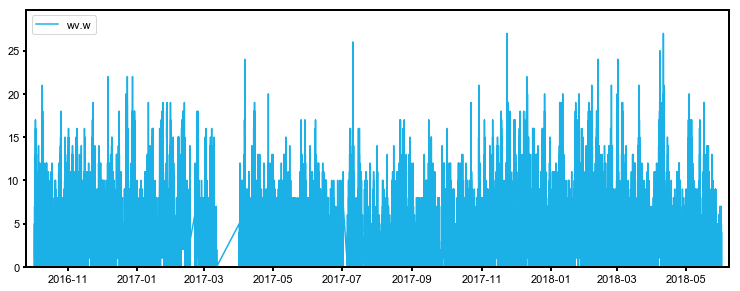

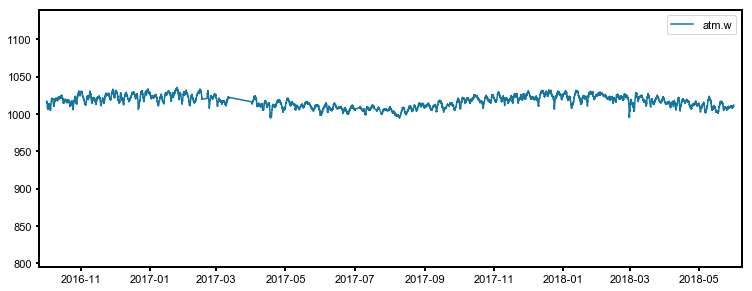

In [22]:
for _ in range(weather_env.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(weather_env.index, weather_env.iloc[:, _], c=cmap[_], label = weather_env.columns[_])
    plt.legend(handles=line)
    plt.axis([weather_env.index[0] - pd.Timedelta('7d'), weather_env.index[-1] + pd.Timedelta('7d'),
              weather_env.iloc[:, _].min() - abs(weather_env.iloc[:, _].min()*0.2), weather_env.iloc[:, _].max()*1.1])
    plt.show()

## Soil

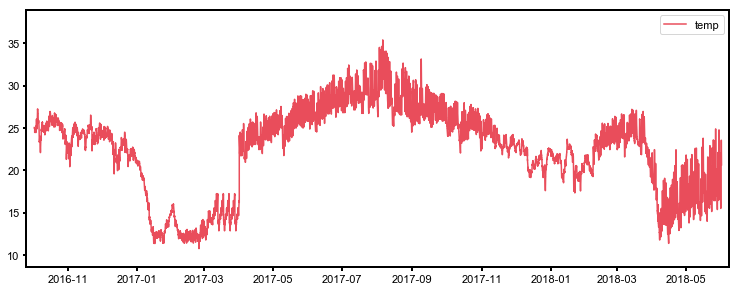

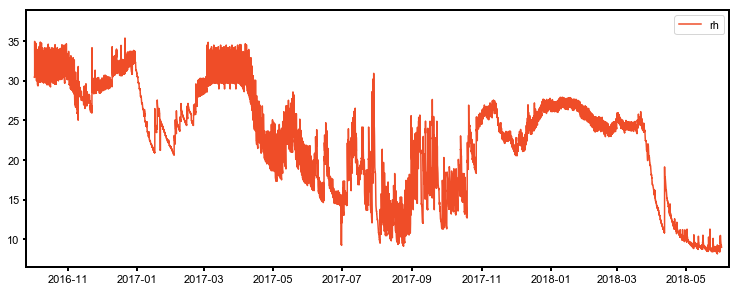

In [23]:
for _ in range(soil_env_mean.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(soil_env_mean.index, soil_env_mean.iloc[:, _], c=cmap[_], label = soil_env_mean.columns[_])
    plt.legend(handles=line)
    plt.axis([soil_env_mean.index[0] - pd.Timedelta('7d'), soil_env_mean.index[-1] + pd.Timedelta('7d'),
              soil_env_mean.iloc[:, _].min() - abs(soil_env_mean.iloc[:, _].min()*0.2), soil_env_mean.iloc[:, _].max()*1.1])
    plt.show()